## Import Library

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType
from pyspark.sql.functions import split, count, when, isnan, col, sum, approxCountDistinct, first, max, lit, expr, min, round
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Sesi Spark 

Sesi Spark (Spark Session) adalah konteks utama untuk berinteraksi dengan Apache Spark, sebuah sistem pemrosesan data yang sangat cepat dan distribusi. Spark Session adalah titik awal untuk menggunakan fitur-fitur Spark, seperti membaca data, melakukan transformasi, dan menjalankan komputasi distribusi.

In [2]:
spark = SparkSession.builder.appName('First Session').getOrCreate()

## 1. Data Collection/Loading

In [3]:
#Defining a Schema
schema = StructType([StructField('Date', StringType(), nullable = True),
                     StructField('Location', StringType(), nullable = True),
                     StructField('MinTemp', FloatType(), nullable = True),
                     StructField('MaxTemp', FloatType(), nullable = True),
                     StructField('Rainfall', FloatType(), nullable = True),
                     StructField('Evaporation', FloatType(), nullable = True),
                     StructField('Sunshine', FloatType(), nullable = True),
                     StructField('WindGustDir', StringType(), nullable = True),
                     StructField('WindGustSpeed', FloatType(), nullable = True),
                     StructField('WindDir9am', StringType(), nullable = True),
                     StructField('WindDir3pm', StringType(), nullable = True),
                     StructField('WindSpeed9am', FloatType(), nullable = True),
                     StructField('WindSpeed3pm', FloatType(), nullable = True),
                     StructField('Humidity9am', FloatType(), nullable = True),
                     StructField('Humidity3pm', FloatType(), nullable = True),
                     StructField('Pressure9am', FloatType(), nullable = True),
                     StructField('Pressure3pm', FloatType(), nullable = True),
                     StructField('Cloud9am', FloatType(), nullable = True),
                     StructField('Cloud3pm', FloatType(), nullable = True),
                     StructField('Temp9am', FloatType(), nullable = True),
                     StructField('Temp3pm', FloatType(), nullable = True),
                     StructField('RainToday', StringType(), nullable = True),
                     StructField('RainTomorrow', StringType(), nullable = True)])

file_path = 'weatherAUS.csv'

df = spark.read.csv(file_path,
                    header = True,
                    inferSchema = True, # Spark akan mencoba untuk menentukan tipe data kolom secara otomatis
                    nanValue = '?')

df = df.withColumn("RainTomorrow", when(df["RainTomorrow"] == "Yes", 1).otherwise(0))

df.show()

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01|  Albury|   13.4|   22.9|     0.6|         NA|      NA|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|      NA|   16.9|   21.8|       No|           0|
|2008-12-02|

## 2. Data Validation

###  Tipe Data

In [4]:
df.dtypes

[('Date', 'date'),
 ('Location', 'string'),
 ('MinTemp', 'string'),
 ('MaxTemp', 'string'),
 ('Rainfall', 'string'),
 ('Evaporation', 'string'),
 ('Sunshine', 'string'),
 ('WindGustDir', 'string'),
 ('WindGustSpeed', 'string'),
 ('WindDir9am', 'string'),
 ('WindDir3pm', 'string'),
 ('WindSpeed9am', 'string'),
 ('WindSpeed3pm', 'string'),
 ('Humidity9am', 'string'),
 ('Humidity3pm', 'string'),
 ('Pressure9am', 'string'),
 ('Pressure3pm', 'string'),
 ('Cloud9am', 'string'),
 ('Cloud3pm', 'string'),
 ('Temp9am', 'string'),
 ('Temp3pm', 'string'),
 ('RainToday', 'string'),
 ('RainTomorrow', 'int')]

In [5]:
# dari pengecekan data terlihat bahwa semuanya adalah data objek (string), perlu diselidiki lebih lanjut

### Dimensi Data

In [6]:
num_rows = df.count()
num_columns = len(df.columns)
print("Jumlah baris dalam dataset:", num_rows)
print("Jumlah kolom dalam dataset:", num_columns)

Jumlah baris dalam dataset: 145460
Jumlah kolom dalam dataset: 23


### Handling Kolom

In [7]:
# Kolom-kolom yang ingin diubah menjadi float
columns_to_convert = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                      'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                      'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
                      'Cloud3pm', 'Temp9am', 'Temp3pm']

# Mengubah tipe data kolom-kolom menjadi float
for column in columns_to_convert:
    df = df.withColumn(column, col(column).cast(FloatType()))

# Menampilkan tipe data kolom setelah perubahan
df.printSchema()
df.show()

root
 |-- Date: date (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: float (nullable = true)
 |-- MaxTemp: float (nullable = true)
 |-- Rainfall: float (nullable = true)
 |-- Evaporation: float (nullable = true)
 |-- Sunshine: float (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: float (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: float (nullable = true)
 |-- WindSpeed3pm: float (nullable = true)
 |-- Humidity9am: float (nullable = true)
 |-- Humidity3pm: float (nullable = true)
 |-- Pressure9am: float (nullable = true)
 |-- Pressure3pm: float (nullable = true)
 |-- Cloud9am: float (nullable = true)
 |-- Cloud3pm: float (nullable = true)
 |-- Temp9am: float (nullable = true)
 |-- Temp3pm: float (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: integer (nullable = false)

+----------+--------+-------+-------+--------+-----------+

In [8]:
# Kolom-kolom yang ingin diubah menjadi string
columns_to_convert_2 = ['Date']

# Mengubah tipe data kolom-kolom menjadi string
for column in columns_to_convert_2:
    df = df.withColumn(column, col(column).cast(StringType()))

# Menampilkan tipe data kolom setelah perubahan
# df.printSchema()

In [9]:
# df.printSchema()

In [10]:
# Menampilkan daftar kolom (atribut)
atribut = df.columns
print(atribut)

['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


In [11]:
# Menggunakan ekspresi SQL untuk mendapatkan nilai dalam bentuk daftar
MaxTemp_list = df.selectExpr("MaxTemp as MaxTempList").collect()

# Ekstrak nilai dari kolom "MaxTempList" menjadi daftar
MaxTemp_list = [row.MaxTempList for row in MaxTemp_list]

# Tampilkan daftar "Location"
print(MaxTemp_list)

[22.899999618530273, 25.100000381469727, 25.700000762939453, 28.0, 32.29999923706055, 29.700000762939453, 25.0, 26.700000762939453, 31.899999618530273, 30.100000381469727, 30.399999618530273, 21.700000762939453, 18.600000381469727, 21.0, 24.600000381469727, 27.700000762939453, 20.899999618530273, 22.899999618530273, 22.5, 25.600000381469727, 29.299999237060547, 33.0, 31.799999237060547, 30.899999618530273, 32.400001525878906, 33.900001525878906, 33.0, 32.70000076293945, 27.200000762939453, 24.200000762939453, 24.399999618530273, 26.5, 23.899999618530273, 28.799999237060547, 34.599998474121094, 35.79999923706055, 37.900001525878906, 38.900001525878906, 28.299999237060547, 28.399999618530273, 30.799999237060547, 32.0, 34.70000076293945, 37.70000076293945, 43.0, 32.70000076293945, 26.700000762939453, 28.399999618530273, 32.20000076293945, 36.599998474121094, 39.900001525878906, 38.099998474121094, 34.0, 35.20000076293945, 30.600000381469727, 34.29999923706055, 38.400001525878906, 38.20000

In [12]:
# Identifikasi variabel kategorik dan numerik
categorical = [col_name for (col_name, col_type) in df.dtypes if col_type == 'string']
numerical = [col_name for (col_name, col_type) in df.dtypes if col_type != 'string']

print('Categorical:', categorical)
print('Numerical:', numerical)

Categorical: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
Numerical: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainTomorrow']


In [13]:
df.describe(numerical).show()

+-------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+
|summary|           MinTemp|           MaxTemp|          Rainfall|      Evaporation|         Sunshine|     WindGustSpeed|      WindSpeed9am|      WindSpeed3pm|       Humidity9am|      Humidity3pm|       Pressure9am|       Pressure3pm|          Cloud9am|         Cloud3pm|           Temp9am|          Temp3pm|       RainTomorrow|
+-------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+
|  count|    

In [14]:
df.select(categorical).show()

+----------+--------+-----------+----------+----------+---------+
|      Date|Location|WindGustDir|WindDir9am|WindDir3pm|RainToday|
+----------+--------+-----------+----------+----------+---------+
|2008-12-01|  Albury|          W|         W|       WNW|       No|
|2008-12-02|  Albury|        WNW|       NNW|       WSW|       No|
|2008-12-03|  Albury|        WSW|         W|       WSW|       No|
|2008-12-04|  Albury|         NE|        SE|         E|       No|
|2008-12-05|  Albury|          W|       ENE|        NW|       No|
|2008-12-06|  Albury|        WNW|         W|         W|       No|
|2008-12-07|  Albury|          W|        SW|         W|       No|
|2008-12-08|  Albury|          W|       SSE|         W|       No|
|2008-12-09|  Albury|        NNW|        SE|        NW|       No|
|2008-12-10|  Albury|          W|         S|       SSE|      Yes|
|2008-12-11|  Albury|          N|       SSE|       ESE|       No|
|2008-12-12|  Albury|        NNE|        NE|       ENE|      Yes|
|2008-12-1

In [15]:
# # Inisialisasi DataFrame untuk statistik deskriptif
# stats_df = df.select(categorical)

# # Hitung statistik deskriptif
# stats = stats_df.agg(
#     *[count(col).alias("count_" + col) for col in categorical],
#     *[approxCountDistinct(col).alias("unique_" + col) for col in categorical],
#     *[first(col, ignorenulls=True).alias("top_" + col) for col in categorical],
#     *[max(col).alias("freq_" + col) for col in categorical]
# )

# # Tampilkan hasil
# stats.show()

## 3. DATA CLEANING

Bagian ini berisi proses penyiapan data berupa data cleaning sebelum
dilakukan explorasi data lebih lanjut. Proses cleaning dapat berupa
memberi nama baru untuk setiap kolom, mengisi missing values,
menghapus kolom yang tidak dipakai, dan lain sebagainya.

##### **Cek Data Duplikat**

In [16]:
# cek duplikat data
duplicate_count = df.groupBy([col(x) for x in df.columns]).count().filter(col("count") > 1).count()
print(duplicate_count)

0


##### **Cek Missing Value**

In [17]:
missing_value_sum = df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])
missing_value_sum.show()

+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|   0|       0|   1485|   1261|    3261|      62790|   69835|          0|        10263|         0|         0|        1767|        3062|       2654|       4507|      15065|      15028|   55888|   59358|   1767|   3609|        0|           0|
+----+--------+-------+-------+-----

In [18]:
# Inisialisasi DataFrame untuk statistik deskriptif
missing_date_count = df.filter(col('Evaporation').isNull()).count()

# Tampilkan hasil
print(f"Jumlah missing values dalam kolom 'Evaporation': {missing_date_count}")

Jumlah missing values dalam kolom 'Evaporation': 62790


##### **Imputing missing values dalam fitur kategorik menggunakan modus**
Metode imputasi dengan modus umumnya digunakan untuk mengisi nilai yang hilang pada variabel categorical yang memiliki distribusi frekuensi yang tidak merata. Hal ini karena dengan menggunakan modus, kita dapat mempertahankan distribusi frekuensi yang ada dan menghindari pergeseran nilai tengah yang mungkin terjadi jika kita menggunakan metode imputasi lain, seperti mean atau median.

In [19]:
# Daftar fitur kategorikal dengan nilai yang hilang
categorical_features_with_null = [feature for feature in df.columns if df.where(col(feature).isNull()).count() > 0]

# Loop melalui setiap fitur kategorikal dengan nilai yang hilang
for each_feature in categorical_features_with_null:
    # Hitung mode
    mode_val = str(df.groupBy(each_feature).agg({"*": "count"}).orderBy(col("count(1)").desc()).first()[each_feature])
    # Isi nilai yang hilang dengan mode
    df = df.na.fill({each_feature: mode_val})


# Tampilkan DataFrame yang telah diisi nilai yang hilang
# df.show()

##### **Menangani missing values dalam fitur numerik**

In [20]:
missing_value_sum = df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])
missing_value_sum.show()

+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|   0|       0|   1485|   1261|       0|      62790|   69835|          0|        10263|         0|         0|           0|           0|          0|       4507|      15065|      15028|   55888|   59358|   1767|   3609|        0|           0|
+----+--------+-------+-------+-----

- Missing values dalam fitur numerik dapat di-impute menggunakan Mean atau Median. Mean sangat sensitif dengan outliers, sehingga missing values pada data numerik diisi dengan median yang lebih kebal dengan outliers. Sebelum itu, outlier dalam fitur numerik perlu ditangani dengan benar.

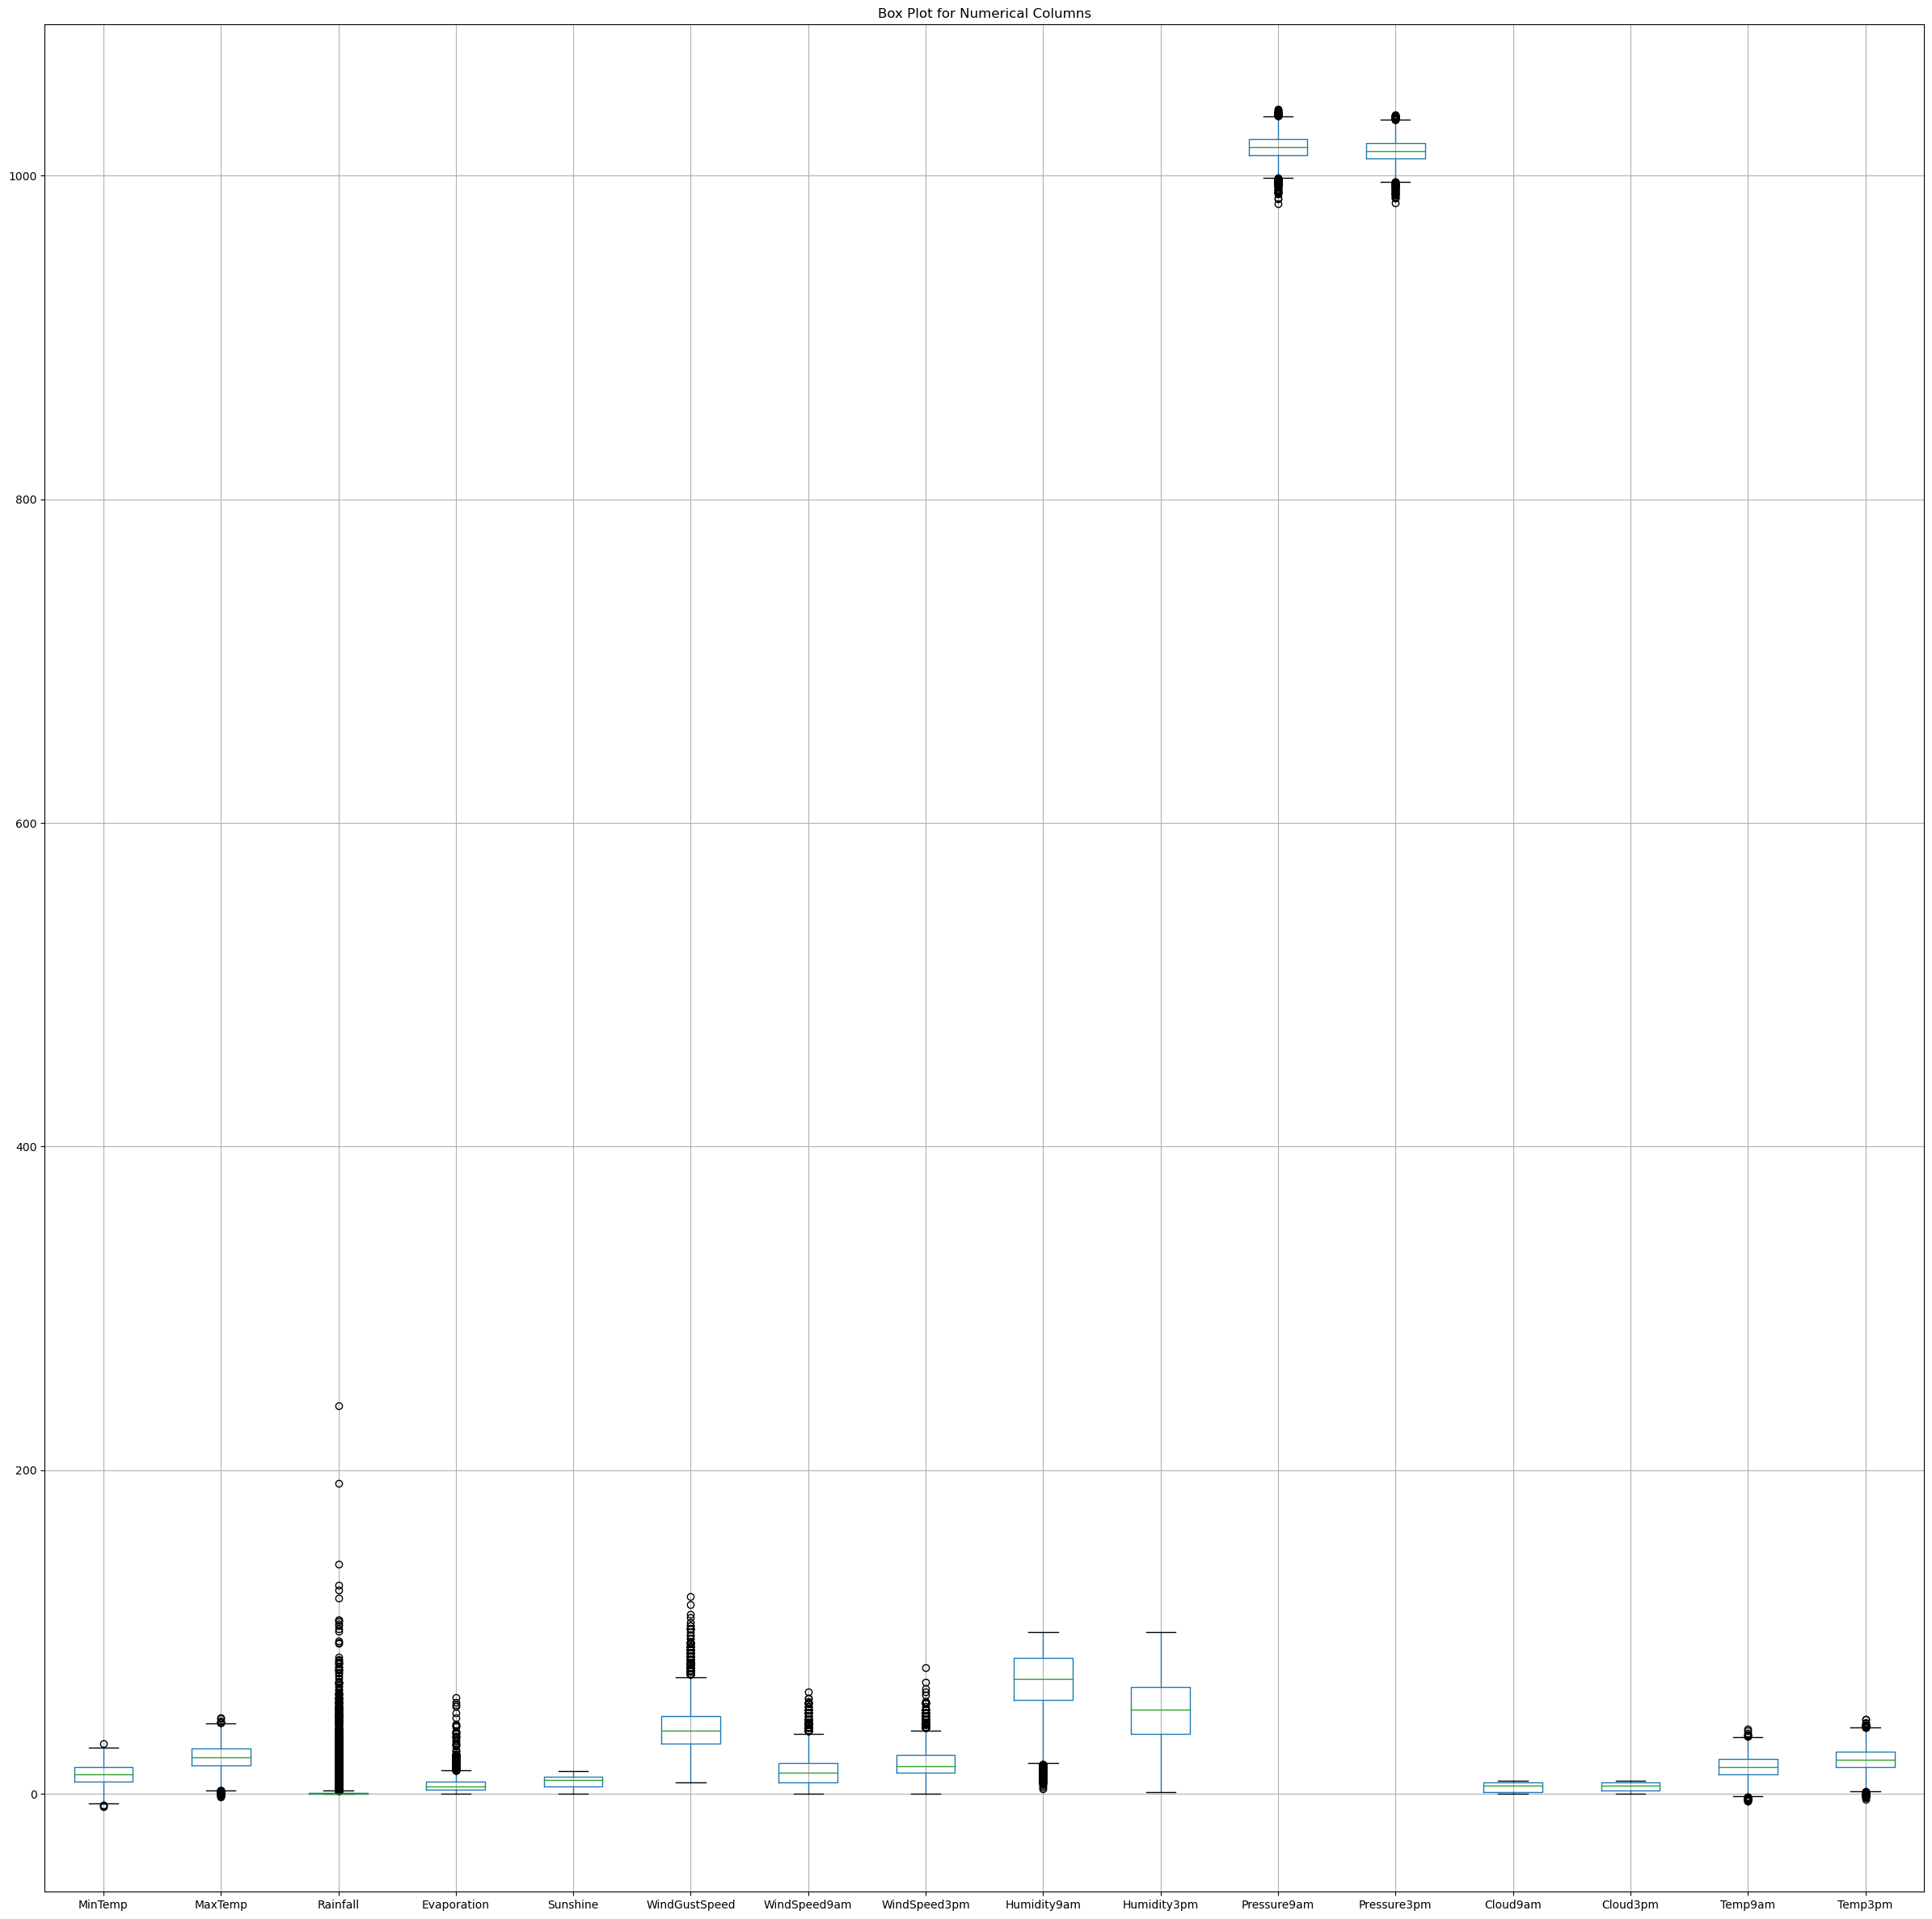

In [21]:
numerical_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 
                  'Evaporation', 'Sunshine', 'WindGustSpeed', 
                  'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                  'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 
                  'Cloud3pm', 'Temp9am', 'Temp3pm']

# Ambil sampel data (misalnya 10%) jika datanya terlalu besar
sampled_data = df.select(*numerical_cols).sample(False, 0.1)

# Konversi DataFrame PySpark ke Pandas DataFrame
pandas_df = sampled_data.toPandas()

# Buat box plot dengan Pandas
pandas_df.boxplot(figsize=(30, 30))

# Tampilkan plot menggunakan Matplotlib
plt.title('Box Plot for Numerical Columns')
plt.show()

- Boxplot menunjukkan outlier dalam jumlah banyak pada atribut MinTemp, MaxTemp, Rainfall, Evaporation, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity9am, Pressure9am, Pressure3pm, Temp9am, dan Temp3pm.

##### Menghilangkan outlier dari fitur numerik

- Mengganti nilai outliers menggunakan nilai lower bound dan upper bound. Nilai lower bound bisa didapatkan menggunakan rumus --> Lb=Q1 -(IQR 1.5). Sementara itu, nilai upper bound bisa didapatkan menggunakan rumus --> Ub=Q3+(IQR 1.5). Dengan IQR = Q3 - Q1.

In [22]:
# from pyspark.sql.functions import expr

features_with_outliers = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 
                          'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 
                          'Humidity9am', 'Pressure9am', 'Pressure3pm', 'Temp9am', 
                          'Temp3pm']

for feature in features_with_outliers:
    q1 = df.approxQuantile(feature, [0.25], 0.01)[0]
    q3 = df.approxQuantile(feature, [0.75], 0.01)[0]
    IQR = q3 - q1
    lower_limit = q1 - (IQR * 1.5)
    upper_limit = q3 + (IQR * 1.5)
    
    df = df.withColumn(feature, 
                       expr(f'CASE WHEN {feature} < {lower_limit} THEN {lower_limit} ' +
                            f'WHEN {feature} > {upper_limit} THEN {upper_limit} ' +
                            f'ELSE {feature} END'))

df.show()


+----------+--------+------------------+------------------+-------------------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+------------------+------------------+--------+--------+------------------+------------------+---------+------------+
|      Date|Location|           MinTemp|           MaxTemp|           Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|       Pressure9am|       Pressure3pm|Cloud9am|Cloud3pm|           Temp9am|           Temp3pm|RainToday|RainTomorrow|
+----------+--------+------------------+------------------+-------------------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+------------------+------------------+--------+--------+------------------+------------------+---------+------------+
|2008-12-01|  Albury|13.399999618530273|22.899999618

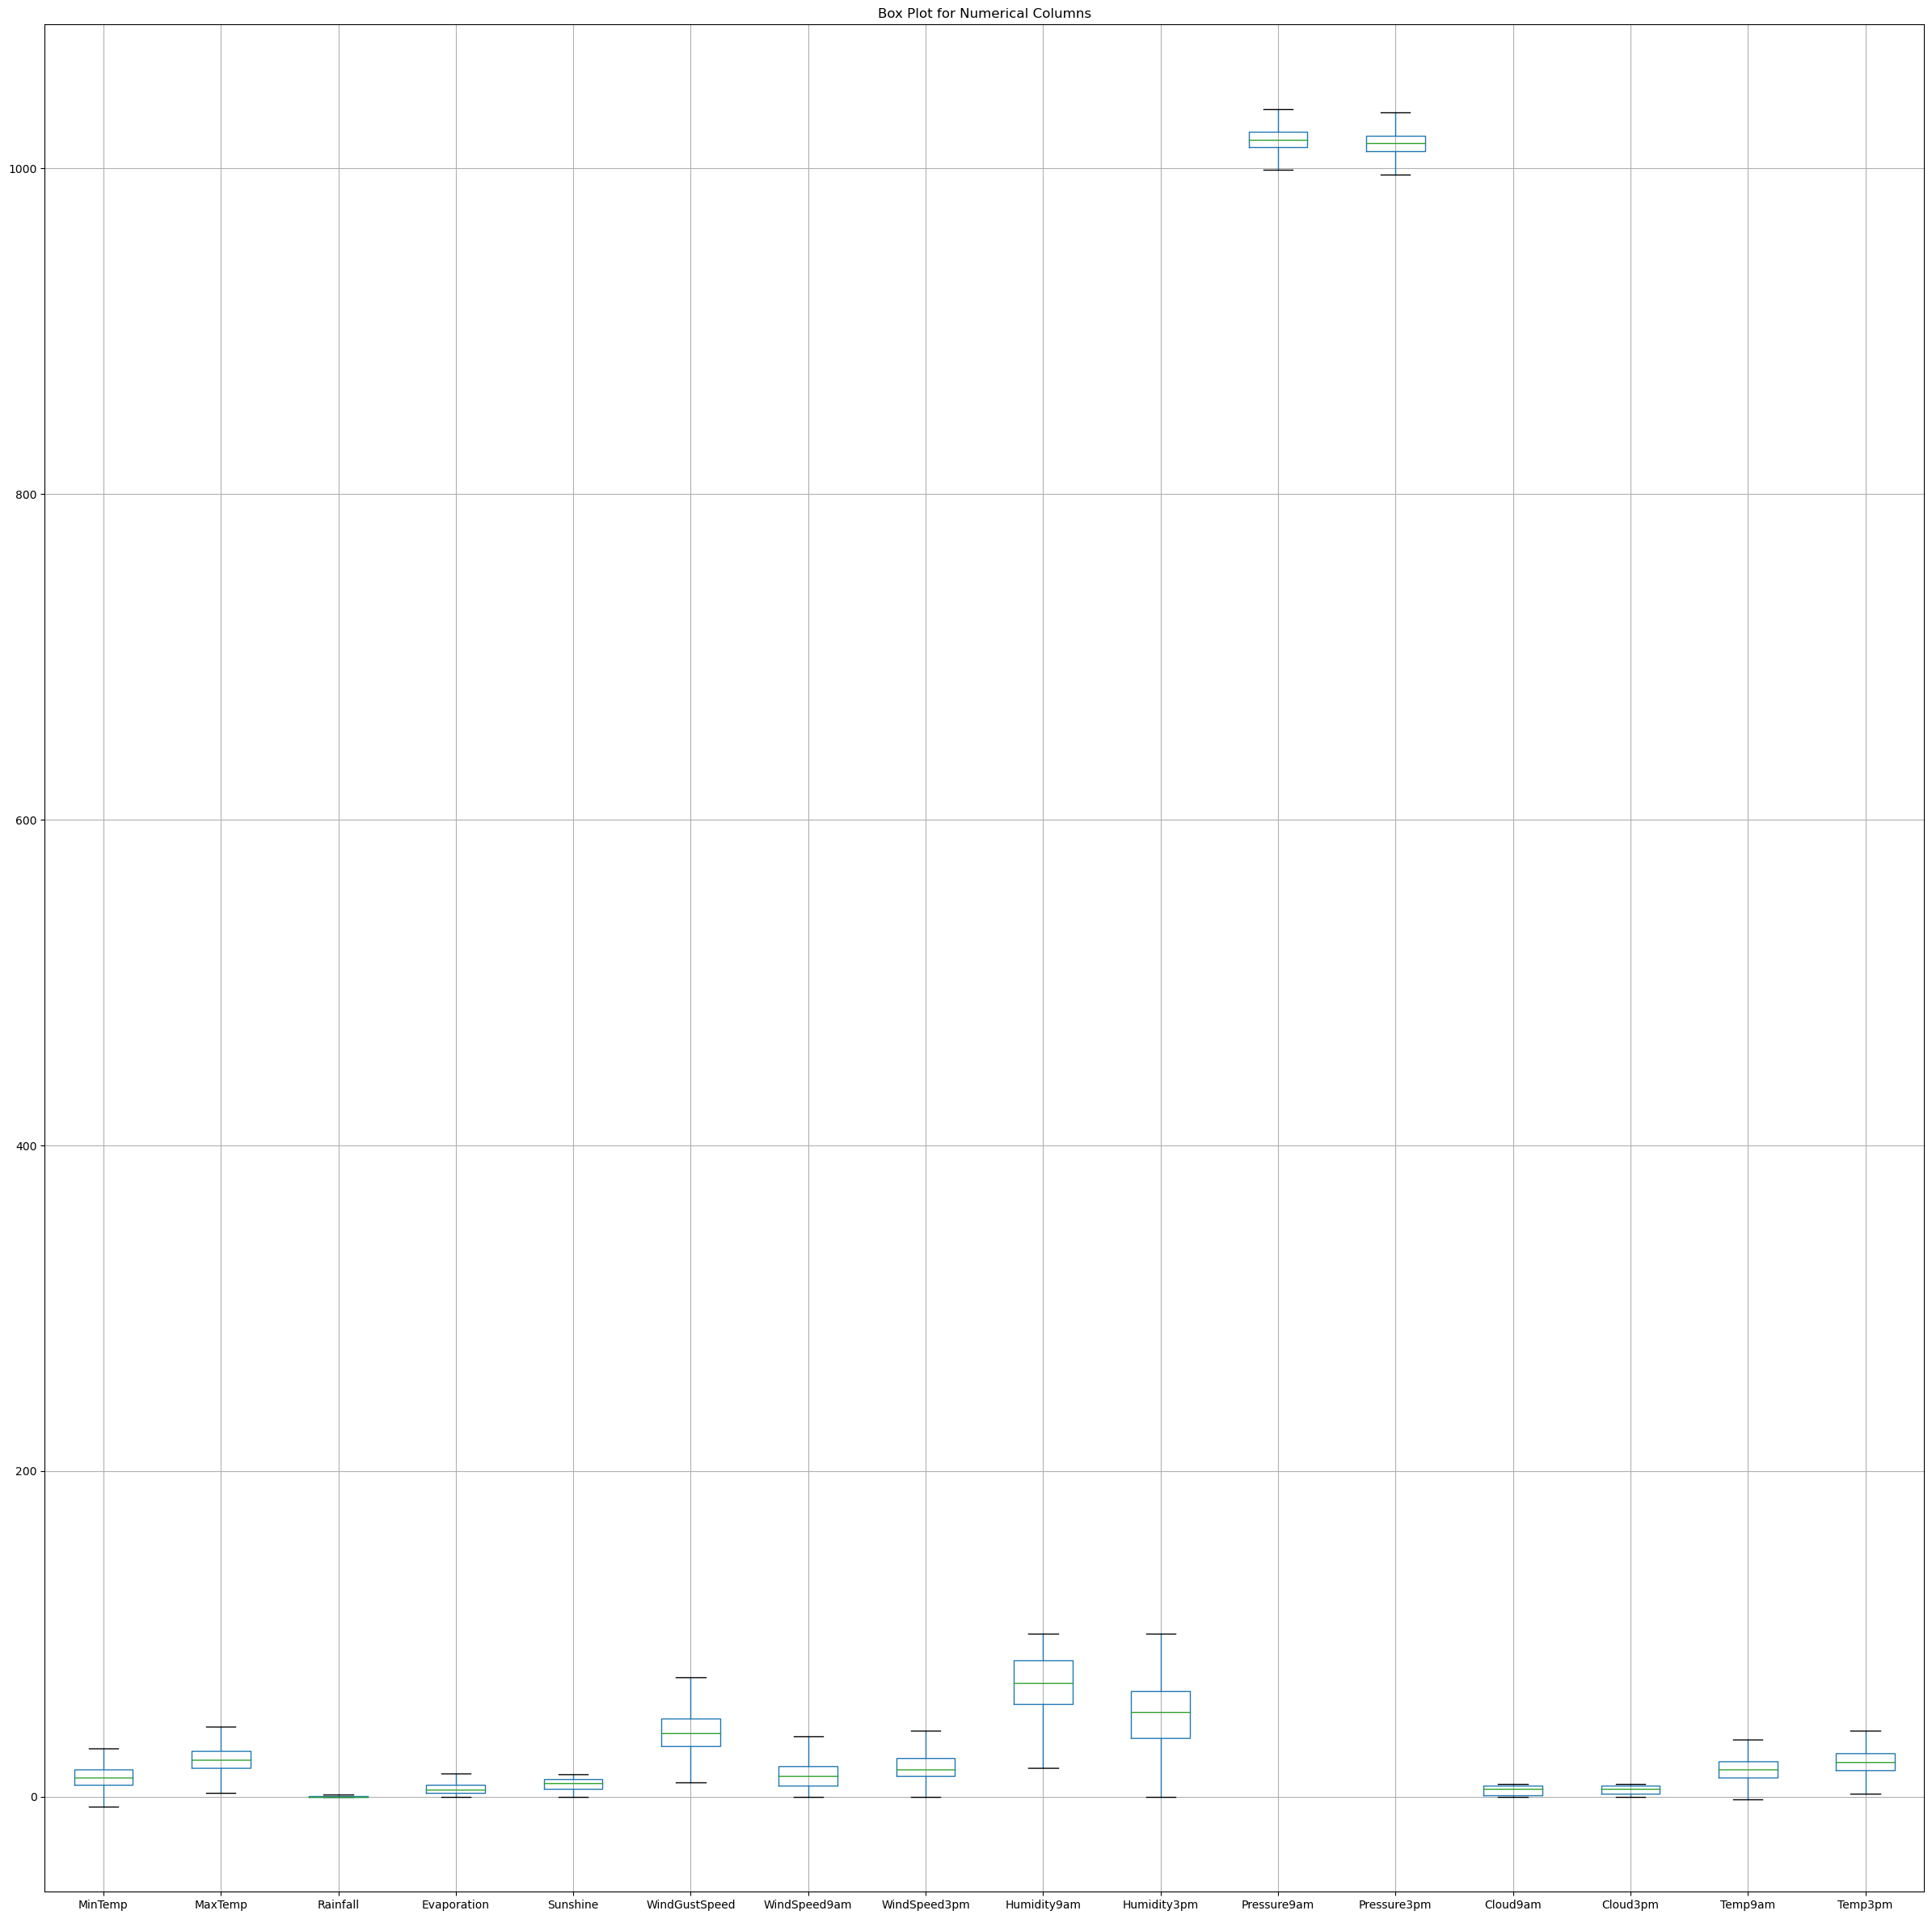

In [23]:
# Ambil kolom numerik dari DataFrame PySpark
numerical_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 
                  'Evaporation', 'Sunshine', 'WindGustSpeed', 
                  'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                  'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 
                  'Cloud3pm', 'Temp9am', 'Temp3pm']

# Ambil sampel data (misalnya 10%) jika datanya terlalu besar
sampled_data = df.select(*numerical_cols).sample(False, 0.1)

# Konversi DataFrame PySpark ke Pandas DataFrame
pandas_df = sampled_data.toPandas()

# Buat box plot dengan Pandas
pandas_df.boxplot(figsize=(30, 30))

# Tampilkan plot menggunakan Matplotlib
plt.title('Box Plot for Numerical Columns')
plt.show()

- Sekarang, fitur numerik sudah bebas dari outliers. Saatnya mengisi missing value yang ada di fitur numerik dengan median

In [24]:
# from pyspark.sql.functions import lit

numerical_features_with_null = [feature for feature in numerical if df.where(col(feature).isNull()).count() > 0]

for feature in numerical_features_with_null:
    median_value = df.approxQuantile(feature, [0.5], 0.01)[0]
    df = df.withColumn(feature, when(col(feature).isNull(), lit(median_value)).otherwise(col(feature)))

df.show()

+----------+--------+------------------+------------------+-------------------+-----------------+-----------------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+------------------+------------------+--------+--------+------------------+------------------+---------+------------+
|      Date|Location|           MinTemp|           MaxTemp|           Rainfall|      Evaporation|         Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|       Pressure9am|       Pressure3pm|Cloud9am|Cloud3pm|           Temp9am|           Temp3pm|RainToday|RainTomorrow|
+----------+--------+------------------+------------------+-------------------+-----------------+-----------------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+------------------+------------------+--------+--------+------------------+------------------+---------+------------+
|2008-1

In [25]:
missing_value_count = df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])
missing_value_count.show()

+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|   0|       0|      0|      0|       0|          0|       0|          0|            0|         0|         0|           0|           0|          0|          0|          0|          0|       0|       0|      0|      0|        0|           0|
+----+--------+-------+-------+-----

In [26]:
numerical

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainTomorrow']

#### ANALISIS:

Dari hasil pengecekan, dapat diketahui bahwa nilai missing value terdapat pada beberapa kolom dengan jumlah yang berbeda - beda. Pada visualisasi banyaknya missing value dapat dilihat pada kolom *Evaporation, Sunshine, Cloud9am dan Cloud3am* memiliki data yang paling banyak missing value. Kami mengisi missing value dengan median untuk data yang bertipe numerical dan pada kolom categorical ditangani dengan modus.

## 4. Exploratory Data Analysis 

Tahap ini dilakukan investigasi pada dataset yang telah didapatkan. EDA juga membantu menentukan langkah-langkah apa yang perlu
dilakukan tentunya dalam hal manipulasi data agar memudahkan dalam menentukan pola

##### Melihat Curah hujan tertinggi dan terendah untuk lokasi Canberra

In [27]:
# from pyspark.sql.functions import min, max, round

result = df.filter(df['Location'] == 'Canberra').agg(round(min('Rainfall'), 1).alias('min'), 
                                                     round(max('Rainfall'), 1).alias('max'))
result.show()


+---+---+
|min|max|
+---+---+
|0.0|1.5|
+---+---+



**Kesimpulan :** Dari hasil diatas maka dapat diketahui bahwa pada lokasi Canberra (ibu kota Australia) curah hujan terendah yaitu 0.0 dan curah hujan tertinggi yaitu 1.5

##### Melihat nilai tertinggi dan terendah pada kecepatan angin (WindGustSpeed)

In [28]:
result = df.select(max('WindGustSpeed')).collect()[0][0]
print(result)

73.5


In [29]:
result = df.select(min('WindGustSpeed')).collect()[0][0]
print(result)

6.0


**Kesimpulan :** Dari hasil diatas maka dapat diketahui bahwa kecepatan angin tertinggi yaitu senilai 73.5km/jam. Sedangkan untuk kecepatan angin terendah didapat dengan nilai 6km/jam.

## 5. Data Preprocessing


In [30]:
# from pyspark.sql.functions import desc

# df.groupBy('Location').count().orderBy(desc('count')).show(5)

In [31]:
# df.dtypes

### Train-Test Split

In [32]:
# Menampilkan daftar kolom (atribut)
atribut = df.columns
print(atribut)

['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


In [33]:
# df.dtypes

In [34]:
# Identifikasi variabel kategorik dan numerik
categorical = [col_name for (col_name, col_type) in df.dtypes if col_type == 'string']
numerical = [col_name for (col_name, col_type) in df.dtypes if col_type != 'string']

print('Categorical:', categorical)
print('Numerical:', numerical)

Categorical: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
Numerical: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainTomorrow']


In [35]:
df.show()

+----------+--------+------------------+------------------+-------------------+-----------------+-----------------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+------------------+------------------+--------+--------+------------------+------------------+---------+------------+
|      Date|Location|           MinTemp|           MaxTemp|           Rainfall|      Evaporation|         Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|       Pressure9am|       Pressure3pm|Cloud9am|Cloud3pm|           Temp9am|           Temp3pm|RainToday|RainTomorrow|
+----------+--------+------------------+------------------+-------------------+-----------------+-----------------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+------------------+------------------+--------+--------+------------------+------------------+---------+------------+
|2008-1

In [36]:
# Kolom-kolom yang ingin diubah menjadi string
columns_to_convert_4 = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 
                        'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 
                        'Cloud3pm', 'Temp9am', 'Temp3pm']

# Mengubah tipe data kolom-kolom menjadi string
for column in columns_to_convert_4:
    df = df.withColumn(column, col(column).cast(FloatType()))

# Menampilkan tipe data kolom setelah perubahan
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: float (nullable = true)
 |-- MaxTemp: float (nullable = true)
 |-- Rainfall: float (nullable = true)
 |-- Evaporation: float (nullable = true)
 |-- Sunshine: float (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: float (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: float (nullable = true)
 |-- WindSpeed3pm: float (nullable = true)
 |-- Humidity9am: float (nullable = true)
 |-- Humidity3pm: float (nullable = true)
 |-- Pressure9am: float (nullable = true)
 |-- Pressure3pm: float (nullable = true)
 |-- Cloud9am: float (nullable = true)
 |-- Cloud3pm: float (nullable = true)
 |-- Temp9am: float (nullable = true)
 |-- Temp3pm: float (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: integer (nullable = false)



In [37]:
# df.dtypes

In [38]:
# # Pilih kolom fitur (X) dengan menghapus kolom 'RainTomorrow'
# X = df.drop('RainTomorrow')

# # Ubah tipe data kolom 'RainTomorrow' ke tipe integer
# df = df.withColumn("RainTomorrow", df["RainTomorrow"].cast("int"))

# # Ambil kolom 'RainTomorrow' sebagai data target (y)
# y = df.select("RainTomorrow")

# # Tampilkan ukuran DataFrame X dan y
# X.count(), y.count()

### Features Selection

Bagian ini berisi proses memilih fitur yang paling berpengaruh terhadap model.

In [39]:
numerical

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainTomorrow']

In [40]:
assembler = VectorAssembler(inputCols=numerical, outputCol='features')
output = assembler.transform(df)
output = output.select('features', 'RainTomorrow')
output = output.withColumnRenamed('RainTomorrow', 'label')

output.show(10)
# numerical

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[13.3999996185302...|    0|
|[7.40000009536743...|    0|
|[12.8999996185302...|    0|
|[9.19999980926513...|    0|
|[17.5,32.29999923...|    0|
|[14.6000003814697...|    0|
|[14.3000001907348...|    0|
|[7.69999980926513...|    0|
|[9.69999980926513...|    1|
|[13.1000003814697...|    0|
+--------------------+-----+
only showing top 10 rows



### Splitting Data

In [41]:
train_data, test_data = output.randomSplit([0.8, 0.2])

# Cetak dimensi dari train_data dan test_data
print('Train Shape: ({}, {})'.format(train_data.count(), len(train_data.columns)))
print('Test Shape: ({}, {})'.format(test_data.count(), len(test_data.columns)))


Train Shape: (116211, 2)
Test Shape: (29249, 2)


### Modelling
Lakukan percobaan model dengan LogisticRegression

In [42]:
my_log_reg_model = LogisticRegression()

fitted_logreg = my_log_reg_model.fit(train_data)
predictions_and_labels = fitted_logreg.evaluate(test_data)
# print(predictions_and_labels.accuracy)
predictions_and_labels.predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-6.1500005722045...|    0|[19.6996586723861...|[0.99999999721678...|       0.0|
|[-5.8000001907348...|    0|[19.3633717946505...|[0.99999999610421...|       0.0|
|[-5.4000000953674...|    0|[19.1260314078521...|[0.99999999506064...|       0.0|
|[-5.3000001907348...|    0|[19.0831547479426...|[0.99999999484425...|       0.0|
|[-5.0,16.70000076...|    0|[19.4074823727099...|[0.99999999627232...|       0.0|
|[-4.9000000953674...|    0|[19.5051457301331...|[0.99999999661917...|       0.0|
|[-4.8000001907348...|    0|[19.3667796130144...|[0.99999999611747...|       0.0|
|[-4.5,14.30000019...|    0|[19.0294140545410...|[0.99999999455960...|       0.0|
|[-4.1999998092651...|    0|[19.6424675764161...|[0.99999999705296...|       0.0|
|[-4.19999980926

In [43]:
my_eval = BinaryClassificationEvaluator()
my_final_roc = my_eval.evaluate(predictions_and_labels.predictions)
my_final_roc

0.9999992931634487

- Output yaitu 0.9999993905268987, adalah hasil dari evaluasi metrik ROC (Receiver Operating Characteristic) yang dihitung oleh BinaryClassificationEvaluator. Nilai ROC ini mendekati 1, yang menunjukkan bahwa model klasifikasi biner Anda memiliki kinerja yang sangat baik dalam membedakan antara kelas positif dan kelas negatif.
- Dalam konteks evaluasi metrik ROC, nilai AUC-ROC mendekati 1 (atau 100%) menunjukkan bahwa model klasifikasi memiliki kinerja yang sangat baik dalam membedakan antara dua kelas yang berbeda.
- Membedakan antara dua kelas yang berbeda itu artinya kelas label dan prediksi model machine learning (ML)

### Visualization

In [44]:
valid_predictions_count = predictions_and_labels.predictions[col("prediction") == col("label")].count()
invalid_predictions_count =  predictions_and_labels.predictions[col("prediction") != col("label")].count()
accuracy_predictions_count = valid_predictions_count / predictions_and_labels.predictions.count() * 100

print("akurasi prediksi yang bener dari label dan prediction: " + str(valid_predictions_count))
print("akurasi prediksi yang salah dari label dan prediction: " + str(invalid_predictions_count))
print("akurasi untuk prediksi yang benar: "+ str(accuracy_predictions_count))

akurasi prediksi yang bener dari label dan prediction: 29249
akurasi prediksi yang salah dari label dan prediction: 0
akurasi untuk prediksi yang benar: 100.0


- akurasi (accuracy) adalah salah satu metrik evaluasi kinerja model yang mengukur sejauh mana model dapat membedakan kelas label yang sebenarnya (actual labels) dengan prediksi yang dibuat oleh model

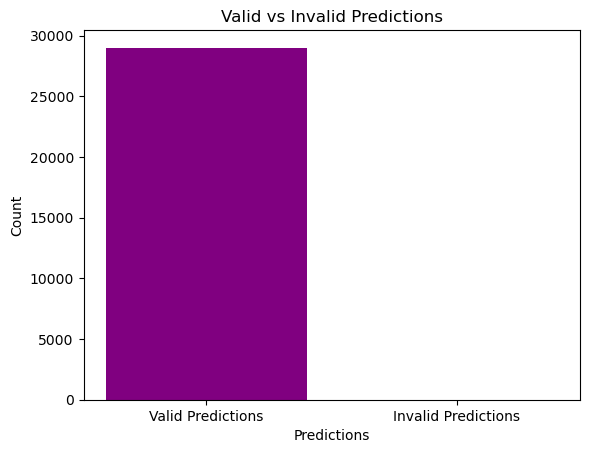

In [45]:
valid_predictions_count = 29006  
invalid_predictions_count = 0  

# Menyiapkan data
categories = ['Valid Predictions', 'Invalid Predictions']
counts = [valid_predictions_count, invalid_predictions_count]

# Membuat grafik batang
plt.bar(categories, counts, color=['purple', 'grey'])
plt.xlabel('Predictions')
plt.ylabel('Count')
plt.title('Valid vs Invalid Predictions')
plt.show()

- Hasil output menunjukkan bahwa dari seluruh prediksi yang telah dilakukan, tidak ada yang salah (0 prediksi yang salah). Seluruh prediksi (28847 prediksi) cocok atau sesuai dengan nilai label yang seharusnya. Dalam istilah akurasi, ini berarti bahwa model atau algoritma yang digunakan untuk membuat prediksi memiliki akurasi sebesar 100%.

- Dengan kata lain, model ini berhasil memprediksi semua data dengan benar sesuai dengan label yang ada. Ini adalah hasil yang sangat baik dan menunjukkan bahwa model tersebut sangat andal dalam melakukan prediksi pada dataset yang digunakan. Akurasi sebesar 100% adalah tujuan yang sangat diinginkan dalam banyak kasus, tetapi Anda juga perlu memeriksa apakah ini adalah hasil yang sesuai dengan ekspektasi atau apakah mungkin ada masalah seperti overfitting.

In [46]:
label_to_zero = predictions_and_labels.predictions[col("label") == 0].count()
label_to_one = predictions_and_labels.predictions[col("label") == 1].count()
accuracy_label_one = label_to_one / predictions_and_labels.predictions.count() * 100

print("data dari kolom label yang satu: " + str(label_to_one))
print("data dari kolom label yang nol: " + str(label_to_zero))
print("akurasi: "+ str(accuracy_label_one))

data dari kolom label yang satu: 6542
data dari kolom label yang nol: 22707
akurasi: 22.366576635098635


In [47]:
label_to_one = 6338  
labe_to_zero = 22668  

# Menyiapkan data
categories = ['No', 'Yes']
counts = [label_to_zero, label_to_one]

# Membuat grafik batang
# plt.bar(categories, counts, color=['grey', 'purple'])
# plt.xlabel('Hari Besok Hujan')
# plt.ylabel('Jumlah')
# plt.title('Jumlah setiap kelas untuk label Hari Besok Hujan')
# plt.show()

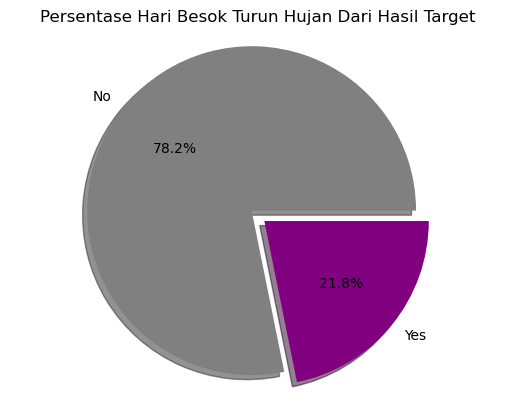

In [48]:
label_to_one = 6338  
labe_to_zero = 22668  

# Menghitung total prediksi
total_predictions = label_to_zero + label_to_one

# Menghitung persentase
percentages = [label_to_zero / total_predictions * 100, label_to_one / total_predictions * 100]

categories = ['No', 'Yes']

# Membuat grafik pie
plt.pie(percentages, labels=categories, autopct='%1.1f%%', explode=[0, 0.1], colors=['grey', 'purple'], shadow=True)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Persentase Hari Besok Turun Hujan Dari Hasil Target')
plt.show()


In [49]:
prediction_to_zero = predictions_and_labels.predictions[col("prediction") == 0].count()
prediction_to_one = predictions_and_labels.predictions[col("prediction") == 1].count()
accuracy_prediction_one = prediction_to_one / predictions_and_labels.predictions.count() * 100

print("data dari kolom prediction yang satu: "+ str(prediction_to_one))
print("data dari kolom prediction yang nol: "+ str(prediction_to_zero))
print("akurasi: "+ str(accuracy_prediction_one))

data dari kolom prediction yang satu: 6542
data dari kolom prediction yang nol: 22707
akurasi: 22.366576635098635


In [50]:
prediction_to_one = 6338 
prediction_to_zero = 22668  

categories = ['No', 'Yes']
counts = [prediction_to_zero, prediction_to_one]

# Membuat grafik batang
# plt.bar(categories, counts, color=['grey', 'purple'])
# plt.xlabel('Hari Besok Hujan')
# plt.ylabel('Jumlah')
# plt.title('Jumlah setiap kelas untuk label Hari Besok Hujan')


for i in range(len(categories)):
    plt.text(categories[i], counts[i] + 200, str(counts[i]), ha='center')

# plt.show()

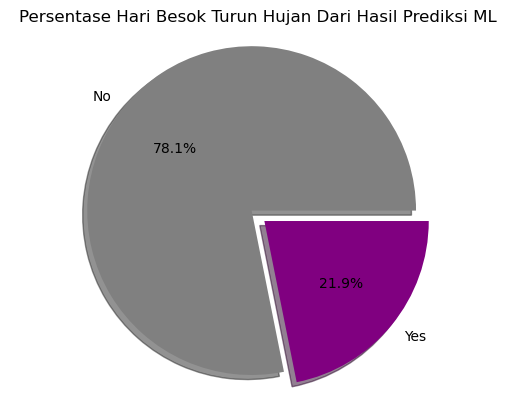

In [54]:
prediction_to_one = 6338
prediction_to_zero = 22668

# Menghitung total prediksi
total_predictions = prediction_to_zero + prediction_to_one

# Menghitung persentase
percentages = [prediction_to_zero / total_predictions * 100, prediction_to_one / total_predictions * 100]

categories = ['No', 'Yes']

# Membuat grafik pie
plt.pie(percentages, labels=categories, autopct='%1.1f%%', explode=[0, 0.1], colors=['grey', 'purple'], shadow=True)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Persentase Hari Besok Turun Hujan Dari Hasil Prediksi ML')
plt.show()


In [52]:
# train_data.printSchema()

In [53]:
# test_data.columns